# Change Detection Module

In [1]:
import os
import warnings
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

from shapely.geometry import Polygon
from utils.ncba import detect_ncba
from utils.preprocessing import filtering_timeseries, save_features
from utils.cloud_detection import (get_s1_col, get_s2cloudless_collection, 
                                   get_matching_s1_s2, get_images)
from utils.plotting import (plot_s2_timeline, unified_closeup_and_ts)
from utils.change_indicators import (kliep_score, compute_change_metrics, generate_residuals, 
                                     build_results_dataframe_from_scalar, get_predictions,
                                     scan_temporal_consistency, summarize_top_changes) 

## Task Parameters 

In [2]:
code = "e06"
## Create subfolder
# os.makedirs(f"../outputs/{code}", exist_ok=True)
# ==== AREA & TIME PARAMETERS ====
## E06
LAT, LON = 40.111, -3.851
START_DATE = "2020-04-01"
END_DATE = "2021-04-01"
POLYGON = [
          [
            [
              -3.8525417211825186,
              40.11065084356787
            ],
            [
              -3.852238995708319,
              40.109152007692956
            ],
            [
              -3.8488771496571417,
              40.10946883754116
            ],
            [
              -3.8490046130137614,
              40.11100422282479
            ],
            [
              -3.8518884714759167,
              40.110809255185956
            ],
            [
              -3.8525417211825186,
              40.11065084356787
            ]
          ]
        ]

In [3]:
polygon_coords = [tuple(coord) for coord in POLYGON[0]]
shape = Polygon(polygon_coords)

## Step 1. Download of the Sentinel-1/2 Time Series Data

In [4]:
## Default download parameters 
CLOUD_FRACTION = 0.5 
PATCH_SIZE = 64 
S2_BANDS = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12", "AOT"] 
S1_BANDS = ["VV", "VH"] 

# Apply the cloudless filter to the collection 
image_collection_s2 = get_s2cloudless_collection(LAT, LON, START_DATE, END_DATE, CLOUD_FRACTION, PATCH_SIZE) 
image_collection_s1 = get_s1_col(LAT, LON, START_DATE, END_DATE, PATCH_SIZE, orbit_pass='DESCENDING') 

matched_s1_col, matched_s2_col, dates = get_matching_s1_s2(image_collection_s1, image_collection_s2) 

# Get the images 
s2_images, s2_profile = get_images(LAT, LON, matched_s2_col, S2_BANDS, PATCH_SIZE, include_clouds=True)
s1_images, s1_profile = get_images(LAT, LON, matched_s1_col, S1_BANDS, PATCH_SIZE) 

print(f"Number of S2 images: {len(s2_images)}, Number of S1 images: {len(s1_images)}")

Original collection size: 145
Collection with cloud score size: 145
Filtered collection size: 94
Original collection size: 119
Filtered collection size: 119
Found 94 valid image pairs.
Matching dates: ['S1:2020-04-05_S2:2020-04-03', 'S1:2020-04-06_S2:2020-04-08', 'S1:2020-04-12_S2:2020-04-13', 'S1:2020-04-18_S2:2020-04-18', 'S1:2020-04-23_S2:2020-04-23', 'S1:2020-04-24_S2:2020-04-26', 'S1:2020-04-30_S2:2020-05-01', 'S1:2020-05-05_S2:2020-05-03', 'S1:2020-05-06_S2:2020-05-06', 'S1:2020-05-06_S2:2020-05-08', 'S1:2020-05-18_S2:2020-05-18', 'S1:2020-05-23_S2:2020-05-21', 'S1:2020-05-23_S2:2020-05-23', 'S1:2020-05-29_S2:2020-05-28', 'S1:2020-05-30_S2:2020-05-31', 'S1:2020-06-05_S2:2020-06-05', 'S1:2020-06-05_S2:2020-06-07', 'S1:2020-06-10_S2:2020-06-10', 'S1:2020-06-11_S2:2020-06-12', 'S1:2020-06-16_S2:2020-06-15', 'S1:2020-06-17_S2:2020-06-17', 'S1:2020-06-22_S2:2020-06-20', 'S1:2020-06-22_S2:2020-06-22', 'S1:2020-06-23_S2:2020-06-25', 'S1:2020-06-28_S2:2020-06-27', 'S1:2020-06-29_S2:2020-

In [5]:
s1_f, s2_f, _ = filtering_timeseries(s1_images, s2_images, normalize=False, local_blocks=2, clear_fraction_thresh=0.70, kld_thresh=0.20)
# Pop the index n
# index = 18
# s1_f.pop(index)
# s2_f.pop(index)

[Align-index] Initial pairs: 94
[Zeros/NaNs] Keep 92 | Remove 2
[Zeros/NaNs] Keep 92 | Remove 2
[Clouds] Keep 92 | Remove 0 (clear threshold=0.70)
[Clouds] Keep 92 | Remove 0 (clear threshold=0.70)
Removing pair idx=0 date_s2=2020-04-03 11:10:03 (KL=0.6324)
Removing pair idx=1 date_s2=2020-04-08 11:10:03 (KL=1.0588)
Removing pair idx=2 date_s2=2020-04-13 11:10:06 (KL=0.9587)
Removing pair idx=3 date_s2=2020-04-18 11:10:02 (KL=0.5604)
Removing pair idx=4 date_s2=2020-04-23 11:10:05 (KL=0.3029)
Removing pair idx=5 date_s2=2020-04-26 11:20:05 (KL=0.2484)
Removing pair idx=6 date_s2=2020-05-01 11:19:59 (KL=0.2384)
Removing pair idx=8 date_s2=2020-05-06 11:20:07 (KL=0.2894)
Removing pair idx=18 date_s2=2020-06-12 11:10:13 (KL=0.2001)
Removing pair idx=26 date_s2=2020-07-02 11:10:11 (KL=0.2196)
Removing pair idx=28 date_s2=2020-07-07 11:10:09 (KL=0.2090)
Removing pair idx=36 date_s2=2020-07-30 11:20:05 (KL=0.2354)
Removing pair idx=37 date_s2=2020-08-01 11:10:12 (KL=0.3014)
Removing pair idx

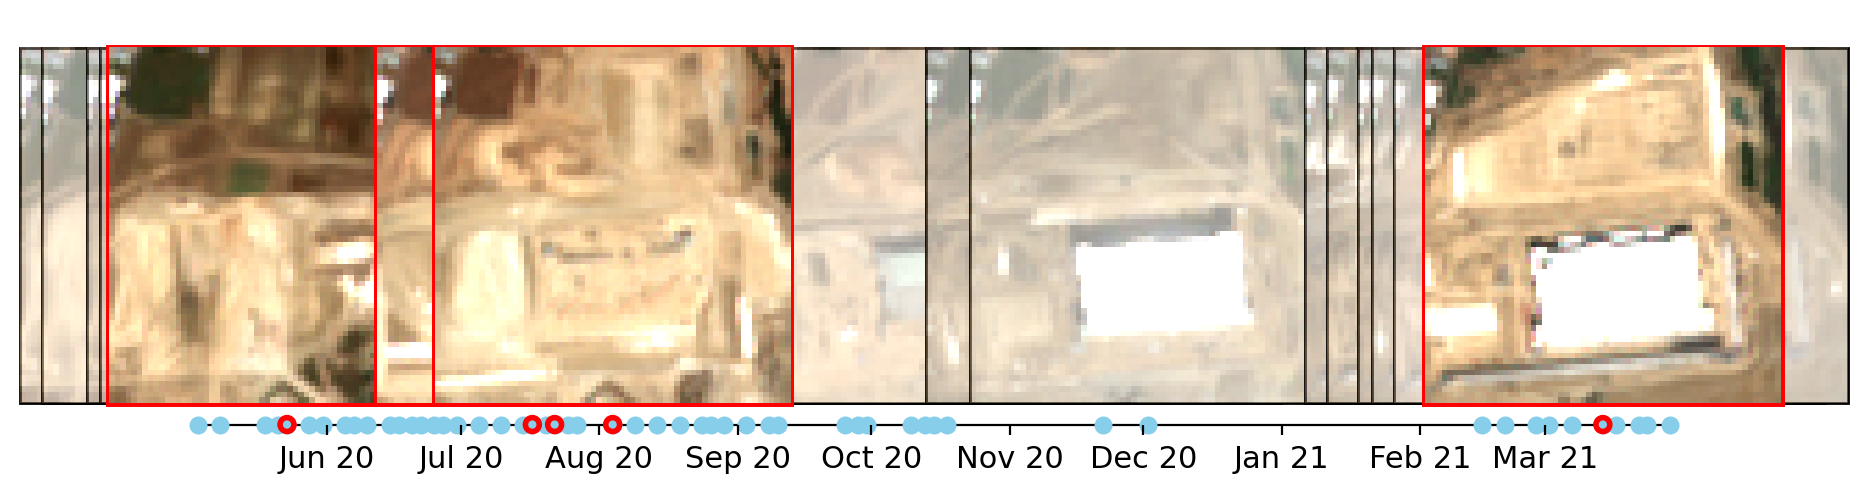

In [6]:
selected_idx = np.random.choice(len(s2_f), size=5, replace=False)
plot_s2_timeline(s2_f, code, selected_idx=selected_idx, show=True, type_image="sentinel2_filtered")

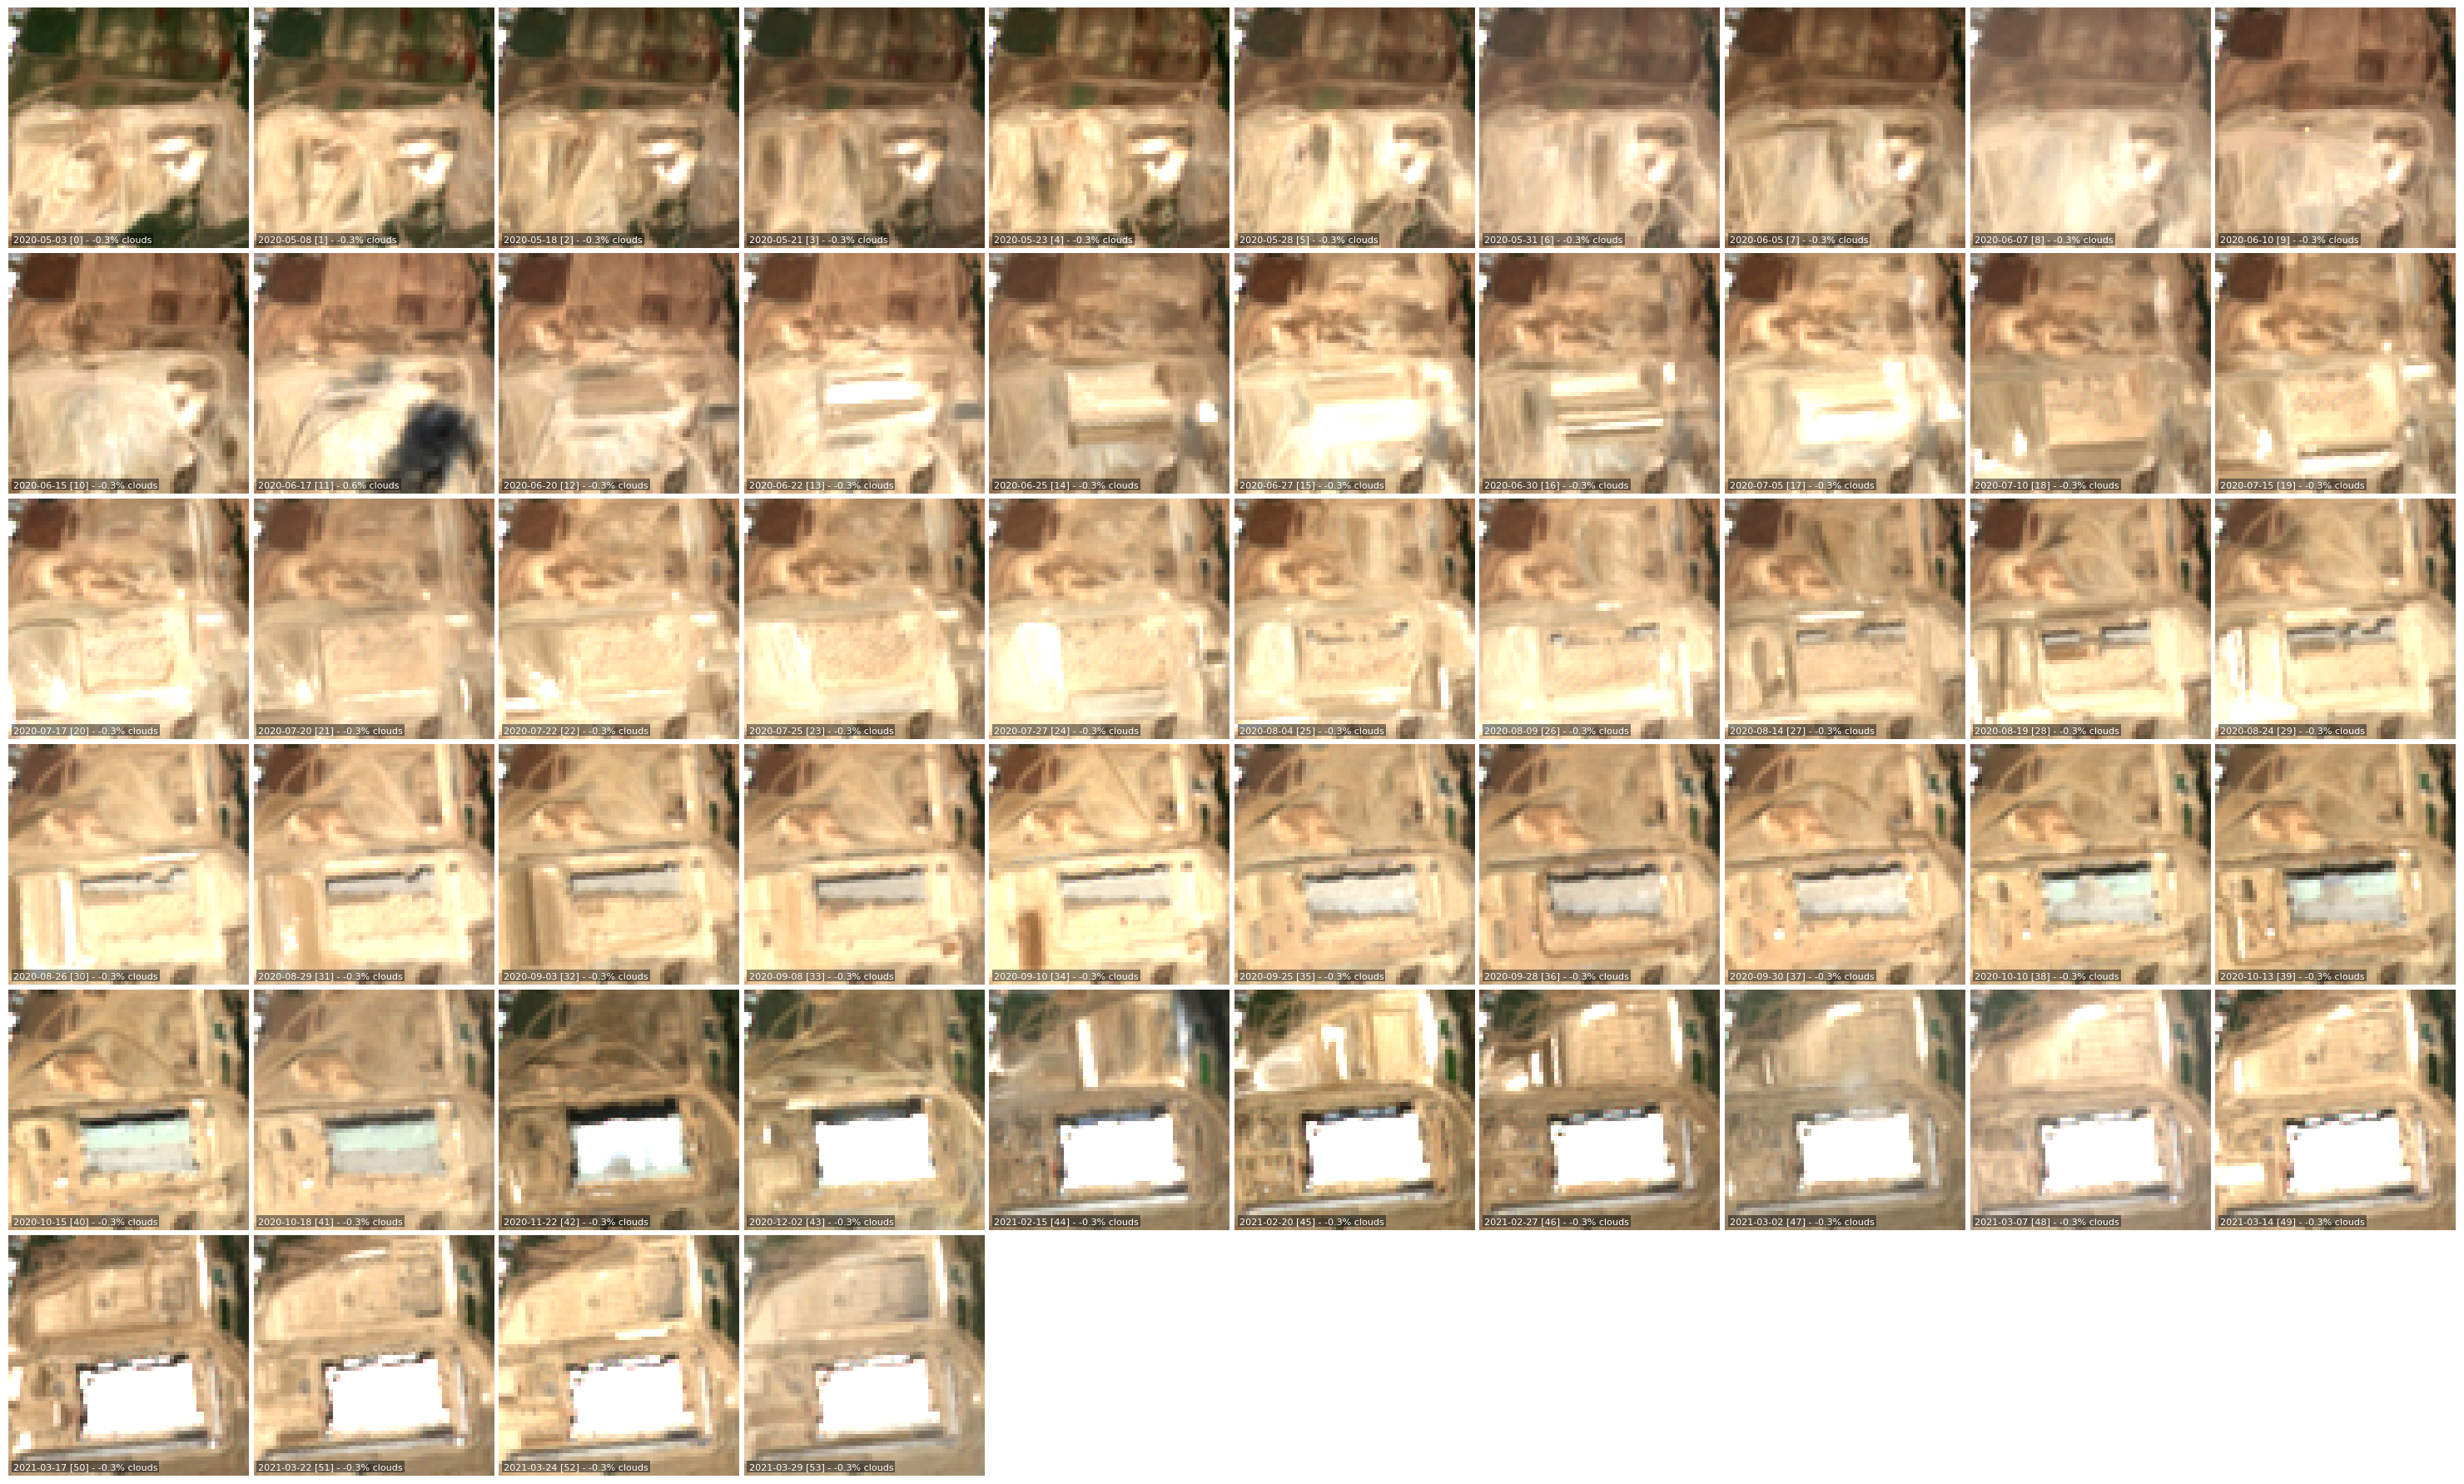

In [7]:
from utils.plotting import plot_entire_timeline
plot_entire_timeline(s2_f, code, show=True, type_image="sentinel2_filtered")

## Step 2. Semantic Segmentation

In [8]:
out_arrays = get_predictions(s1_f=s1_f, s2_f=s2_f, method="multi_task")

[multi_task] 1/54 -> 2020-05-03 11:10:10
[multi_task] 2/54 -> 2020-05-08 11:10:04
[multi_task] 3/54 -> 2020-05-18 11:10:06
[multi_task] 4/54 -> 2020-05-21 11:20:03
[multi_task] 5/54 -> 2020-05-23 11:10:12
[multi_task] 6/54 -> 2020-05-28 11:10:08
[multi_task] 7/54 -> 2020-05-31 11:20:04
[multi_task] 8/54 -> 2020-06-05 11:20:09
[multi_task] 9/54 -> 2020-06-07 11:10:09
[multi_task] 10/54 -> 2020-06-10 11:20:05
[multi_task] 11/54 -> 2020-06-15 11:20:09
[multi_task] 12/54 -> 2020-06-17 11:10:09
[multi_task] 13/54 -> 2020-06-20 11:20:05
[multi_task] 14/54 -> 2020-06-22 11:10:12
[multi_task] 15/54 -> 2020-06-25 11:20:08
[multi_task] 16/54 -> 2020-06-27 11:10:09
[multi_task] 17/54 -> 2020-06-30 11:20:05
[multi_task] 18/54 -> 2020-07-05 11:20:07
[multi_task] 19/54 -> 2020-07-10 11:20:04
[multi_task] 20/54 -> 2020-07-15 11:20:07
[multi_task] 21/54 -> 2020-07-17 11:10:08
[multi_task] 22/54 -> 2020-07-20 11:20:04
[multi_task] 23/54 -> 2020-07-22 11:10:12
[multi_task] 24/54 -> 2020-07-25 11:20:08
[

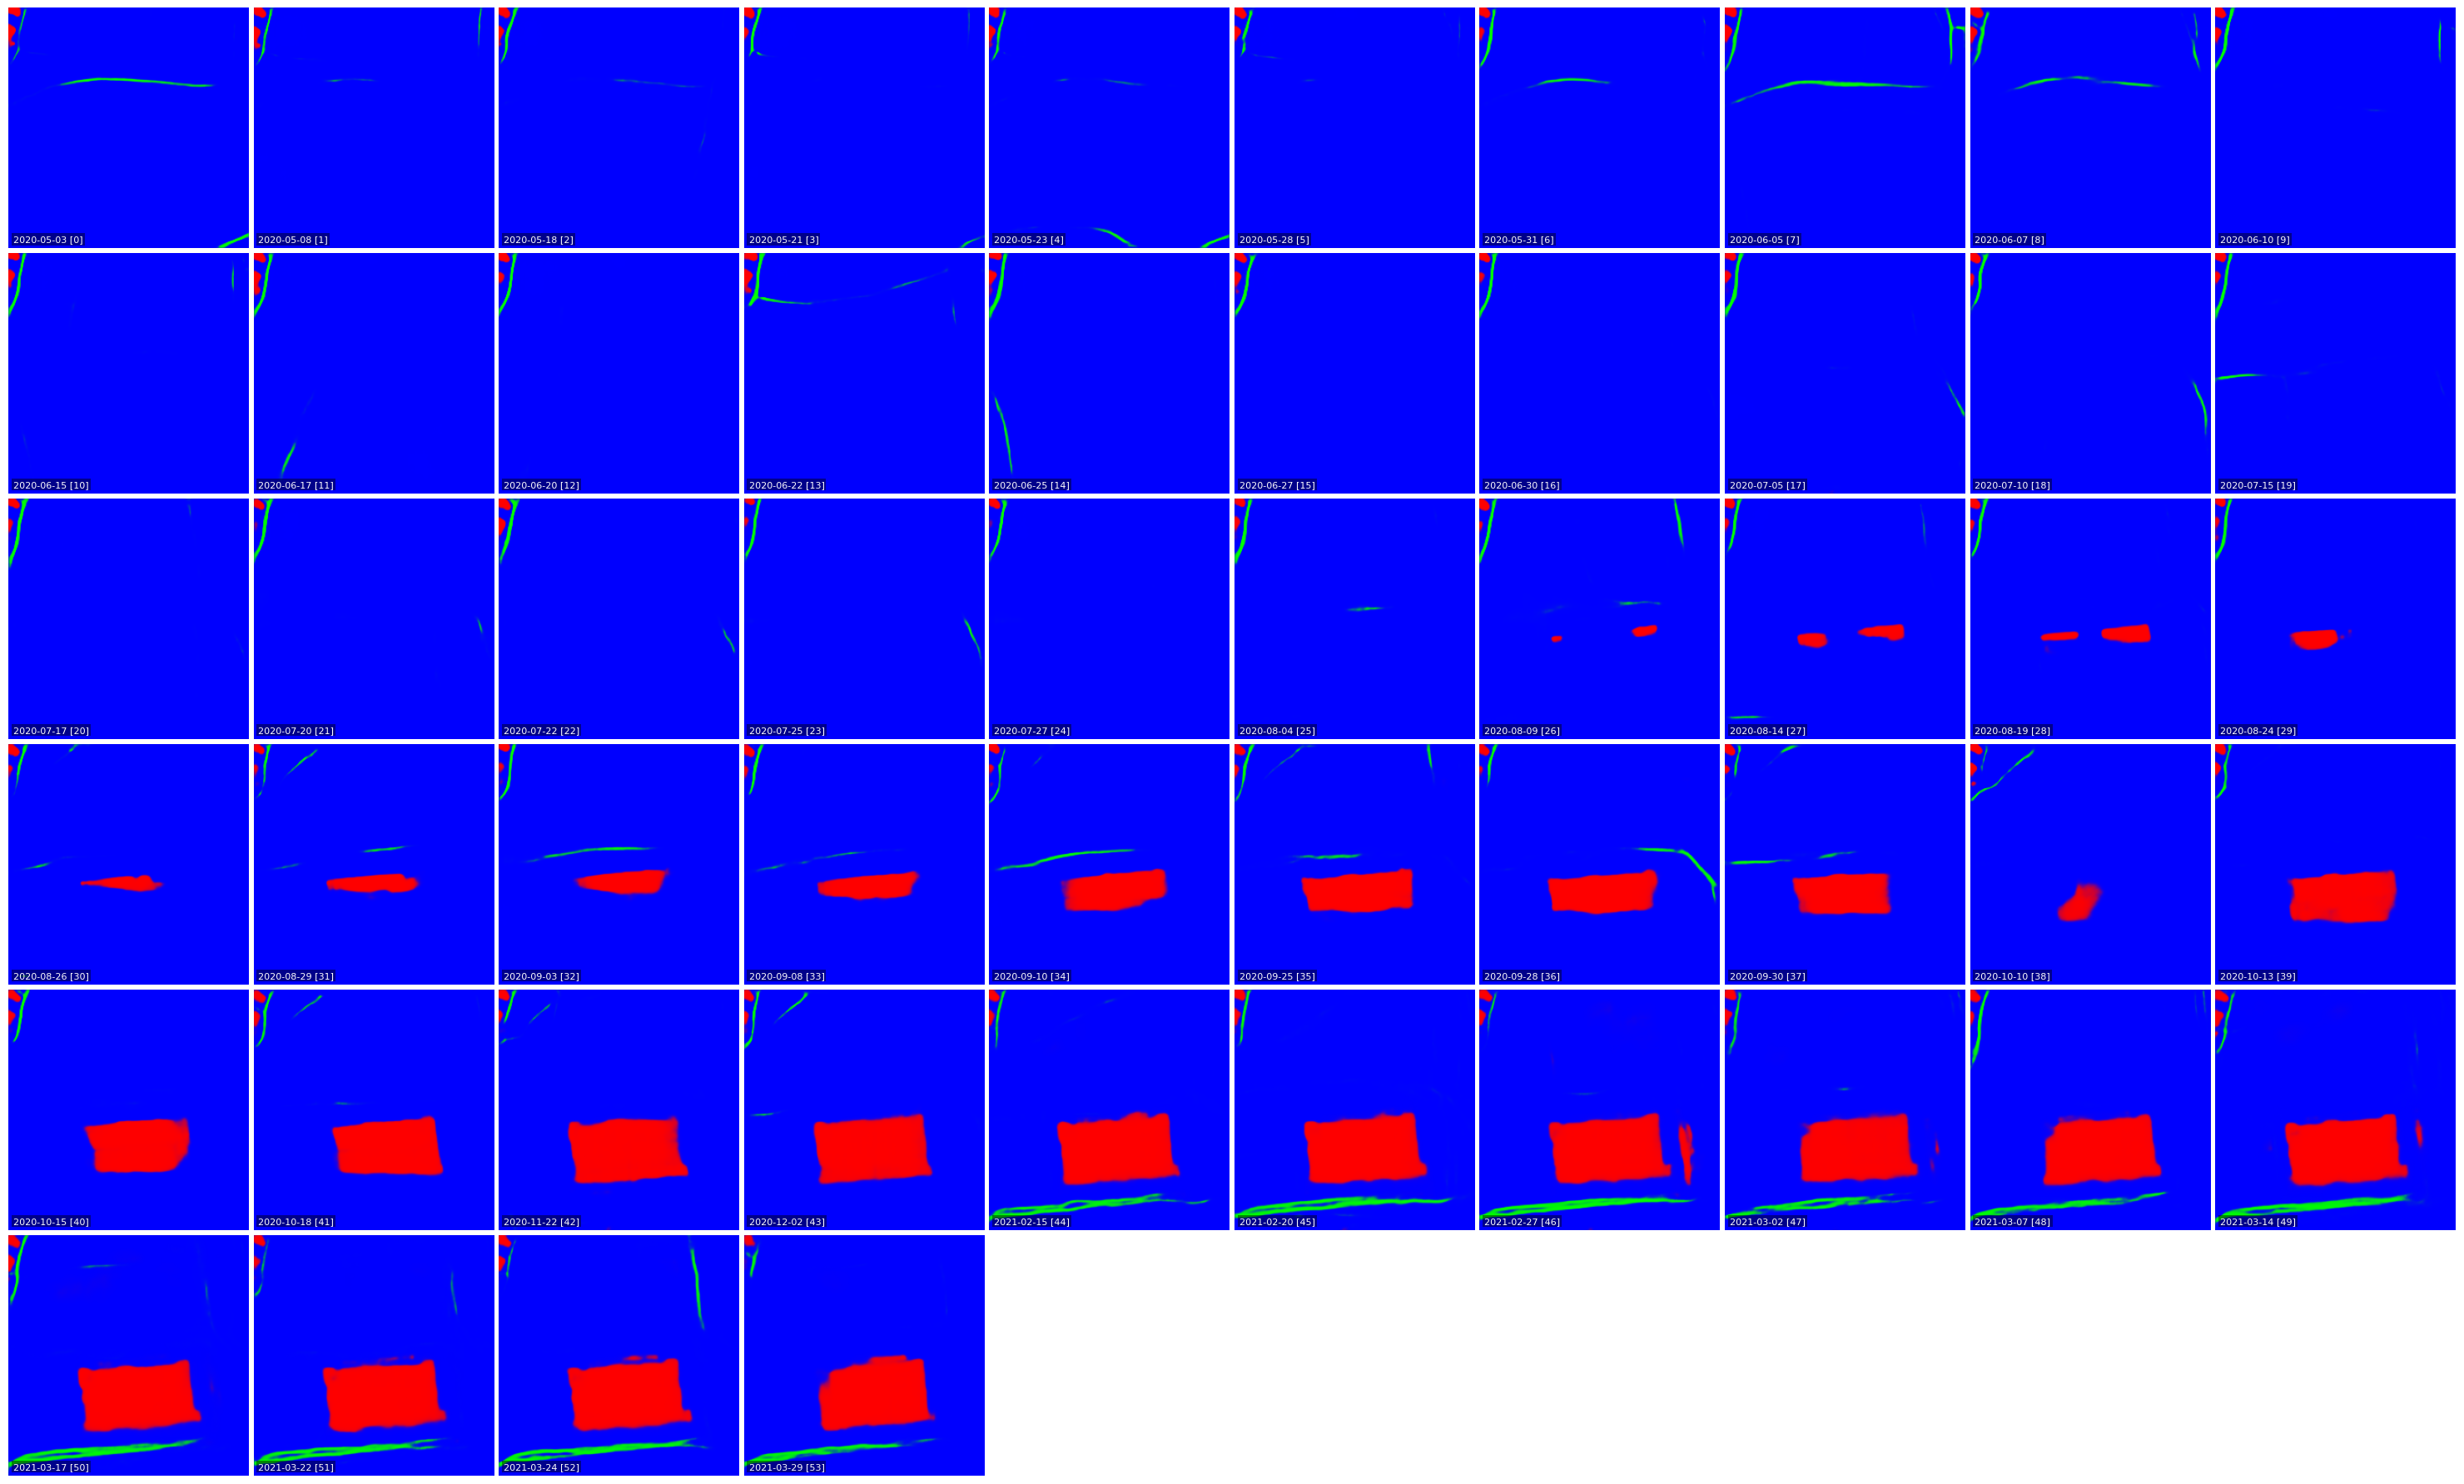

In [9]:
from utils.plotting import plot_entire_timeline
plot_entire_timeline(out_arrays, code="v07", show=True, type_image="predicted")

## Step 3. Get the change indicators

In [10]:
# Get the KLIEP Score 
features = save_features(s2_f, s1_f, s2_profile, shape, model="multi_task")
kliep_scores, kliep_t1s, kliep_t2s = kliep_score(np.array(features["features"]), cloud_band_index=3, cloud_thresh=70) 

# Generate the residuals 
residuals_df = generate_residuals(features, kliep_t1s, s2_f, period=3) 

# Get the metrics 
results = [] 
for i, (t1, t2) in enumerate(zip(kliep_t1s, kliep_t2s)): 
    # toma 3 primeros canales para métricas (ajusta si necesitas otros) 
    feat_t1 = features["features"][t1][:3] 
    feat_t2 = features["features"][t2][:3] 
    metrics_dict = compute_change_metrics(feat_t1, feat_t2, class_names=["building", "road", "background"], 
                                          bg_full_tol=0.01, delta_frac=0.1, presence_frac=0.1)
    results.append({ "t1": int(t1), 
                    "t2": int(t2), 
                    "score": float(kliep_scores[i]), 
                    "date_change": pd.to_datetime(s2_f[int(t2)]["date"]).strftime("%Y-%m-%d"), 
                    "cva_mag_mean": float(np.nanmean(metrics_dict["magnitude_map"])), 
                    "dominant_label": metrics_dict["dominant_label"], 
                    "rate_bu_change": float(metrics_dict["change_rates"]["building"]), 
                    "rate_ro_change": float(metrics_dict["change_rates"]["road"]), 
                    "rate_bk_change": float(metrics_dict["change_rates"]["background"])}) 
    
# Create the dataframe 
df_metrics = build_results_dataframe_from_scalar(results, area_id="A01", series_id="S01", residuals_df=residuals_df) 
df_metrics.head(6)

,nro,series_id,area_id,rank,t1,t2,date_change,kliep_abs,cva_mag_mean,dominant_label,rate_bu_change,rate_ro_change,rate_bk_change,residual_building,residual_roads,class_fracs_t1,class_fracs_t2
0,27,S01,A01,1,30,31,2020-08-29,0.5178,0.1053,building → building,0.0709,0.0,-0.0709,-0.035184,-0.000013,None,None
1,35,S01,A01,2,38,39,2020-10-13,0.4187,0.7129,building → building,0.5053,0.0,-0.5053,-0.260592,-0.000011,None,None
2,24,S01,A01,3,27,28,2020-08-19,0.3423,0.0887,building → building,0.0139,0.0,-0.0139,0.009014,-0.000069,None,None
3,42,S01,A01,4,45,46,2021-02-27,0.3210,0.0517,building → building,-0.0306,0.0,0.0306,0.002640,0.000067,None,None
4,49,S01,A01,5,52,53,2021-03-29,0.3187,0.1060,building → building,-0.0284,0.0,0.0284,-0.005298,-0.000094,None,None
5,43,S01,A01,6,46,47,2021-03-02,0.2813,0.1044,building → building,-0.0098,0.0,0.0098,-0.014789,-0.000071,None,None


In [11]:
# 1) Residuales (igual)
residuals_df = generate_residuals(features, kliep_t1s, s2_f, period=3)

# 2) Escaneo con suavizado temporal de probabilidades (EMA)
df_windows = scan_temporal_consistency(
    df_metrics,
    window_pairs=7, step_pairs=1,
    residuals_df=residuals_df,
    repeats_required_pre=0, repeats_required_post=3,
    rate_change_threshold=0.05,
    window_mode="row",
    anchor="center"
)

df_windows.head(5)

,series_id,area_id,start_t1,end_t2,first_label,end_label,center_label,center_t1,center_t2,from_class,to_class,prev_block_ok,post_block_ok,rate_sum_to,residual_min_center,residual_ok,pair_t1s,pair_t2s,consistent,reason
0,S01,A01,0,10,background → background,background → background,background → background,3,4,background,background,True,True,0.0,-0.006938,True,"[0, 1, 2, 3, 4, 7, 9]","[1, 2, 3, 4, 7, 9, 10]",False,no_significant_change
1,S01,A01,1,12,background → background,background → background,background → background,4,7,background,background,True,True,0.0,-0.000039,True,"[1, 2, 3, 4, 7, 9, 10]","[2, 3, 4, 7, 9, 10, 12]",False,no_significant_change
2,S01,A01,2,13,background → background,background → background,background → background,7,9,background,background,True,True,0.0,-0.011302,True,"[2, 3, 4, 7, 9, 10, 12]","[3, 4, 7, 9, 10, 12, 13]",False,no_significant_change
3,S01,A01,3,14,background → background,background → background,background → background,9,10,background,background,True,True,0.0,-0.006938,True,"[3, 4, 7, 9, 10, 12, 13]","[4, 7, 9, 10, 12, 13, 14]",False,no_significant_change
4,S01,A01,4,15,background → background,background → background,background → background,10,12,background,background,True,True,0.0,-0.000013,True,"[4, 7, 9, 10, 12, 13, 14]","[7, 9, 10, 12, 13, 14, 15]",False,no_significant_change


In [12]:
# Summarize_top_changes
top_df = summarize_top_changes(df_metrics, df_windows, top_n=3)
top_df.to_csv(f"../outputs/{code}/top_changes_{code}.csv", index=False) 
top_df

,series_id,area_id,center_t1,to_class,kliep_abs,cva_mag_mean,overall_score,change_date
0,S01,A01,38,building,0.4187,0.7129,0.56580,2020-10-13
1,S01,A01,30,building,0.5178,0.1053,0.31155,2020-08-29
2,S01,A01,33,building,0.2305,0.2546,0.24255,2020-09-10


In [13]:
# --- Uso con tu serie (edificios) ---
if code.startswith("e"):
    pred = np.array([np.nanmean(features['features'][i][0]) for i in range(len(features['features']))])
elif code.startswith("v"):
    pred = np.array([np.nanmean(features['features'][i][1]) for i in range(len(features['features']))])

results, thr, mags = detect_ncba(pred, alpha=1.0)
print("threshold =", thr)

for i, r in enumerate(results):
    print(i, r)

# Correspondencia de índices a fechas
date_change = pd.to_datetime(s2_f[int(r.change_t)]["date"]).strftime("%Y-%m-%d")
print(f"Fecha del cambio: {date_change}")

# Create a csv
df_ncba = pd.DataFrame([{
    "change_t": int(r.change_t),
    "t1": int(r.q1),
    "t2": int(r.q2),
    "magnitude": float(r.change_mag),
    "date_change": date_change
}])

df_ncba.to_csv(f"../outputs/{code}/ncba_{code}.csv", index=False)
df_ncba

threshold = 0.7605720616886281
0 NCBAResult(q1=38, q2=39, change_t=39, change_mag=0.7605720616886281, is_ncba=False)
Fecha del cambio: 2020-10-13


,change_t,t1,t2,magnitude,date_change
0,39,38,39,0.760572,2020-10-13


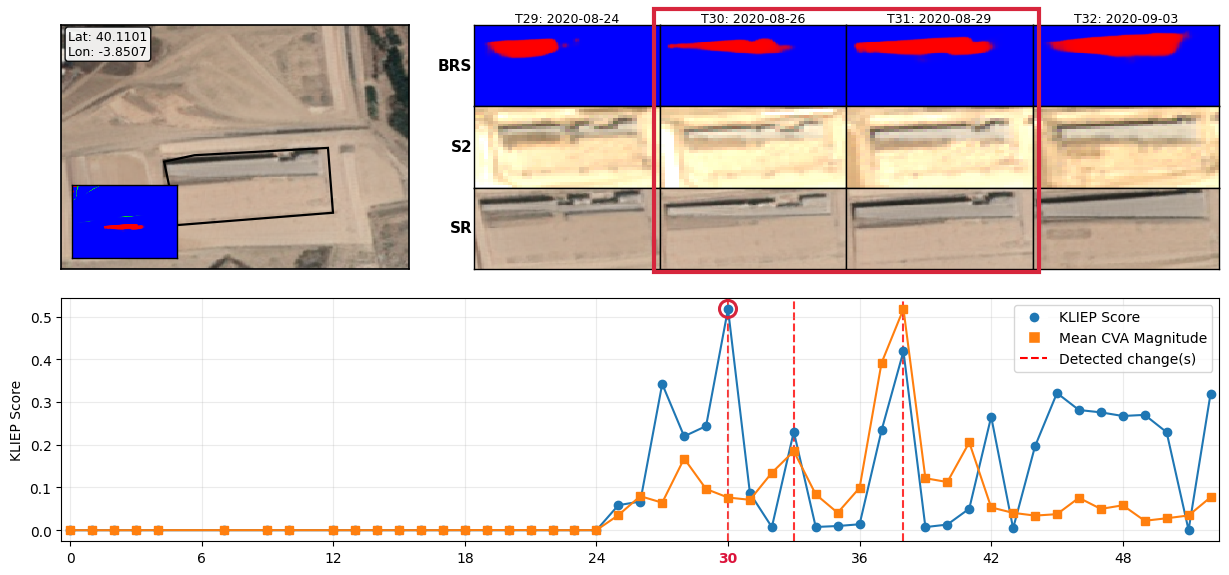

In [15]:
# from utils.plotting import unified_closeup_and_ts
idx = 30
unified_closeup_and_ts(out_arrays=out_arrays, s2_profile=s2_profile, shape=shape, idx=idx, 
                       df_metrics=df_metrics,
                       factor=1, circle_size=150, top_df=top_df, type="building",
                       plot_polygon_in_closeups=False,
                       panel_t1s=kliep_t1s, figsize=(12,6), overview_frac=0.30, top_panel_frac=0.5)